In [14]:
%%capture
!pip install pdpbox

In [15]:
!pip install lime

In [16]:
!pip install shap

In [65]:
%matplotlib notebook
import matplotlib.pyplot as plt

In [17]:
from collections import defaultdict
import os
import warnings

import lime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pdpbox import pdp
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

import shap
from tqdm.auto import tqdm

In [18]:
%matplotlib inline


warnings.filterwarnings("ignore")

sns.set_style("dark") # Theme for plots as Da1. Dataset Overviewrk
sns.set_palette("viridis")

**Prediction of Mohs Hardness**

In [19]:
train_data = pd.read_csv("/train.csv", index_col="id", dtype=np.float32)
test_data = pd.read_csv("/test.csv",index_col="id", dtype=np.float32)

sample = pd.read_csv("/sample_submission.csv")
sample["Hardness"] = 0

**ETA**

In [20]:
train_data.head(10)

allelectrons_Total  density_Total  allelectrons_Average  val_e_Average  \
id                                                                            
0.0               100.0       0.841611             10.000000       4.800000   
1.0               100.0       7.558488             10.000000       4.800000   
2.0                76.0       8.885992             15.600000       5.600000   
3.0               100.0       8.795296             10.000000       4.800000   
4.0               116.0       9.577996             11.600000       4.800000   
5.0               131.0      24.529327             21.833334       4.666667   
6.0                50.0       3.253996             10.000000       4.800000   
7.0                30.0       2.701748              6.000000       4.000000   
8.0               120.0      14.632000             12.000000       4.800000   
9.0                97.0      13.477328             12.812500       5.000000   

     atomicweight_Average  ionenergy_Average  el_neg_chi_Average  \
id                                                                 
0.0             20.612526          11.088100            2.766000   
1.0             20.298893          12.040830            2.755000   
2.0             33.739258          12.086300            2.828000   
3.0             20.213348          10.948500            2.648000   
4.0             24.988132          11.824480            2.766000   
5.0             50.131500          11.948200            2.858333   
6.0             20.077019          11.023840            2.727000   
7.0             11.663548          12.415840            2.766000   
8.0             24.808517          11.331820            2.870000   
9.0             24.988132          11.037175            2.818750   

     R_vdw_element_Average  R_cov_element_Average  zaratio_Average  \
id                                                                   
0.0               1.732000               0.860000         0.496070   
1.0               1.631000               0.910000         0.492719   
2.0               1.788000               0.864000         0.481478   
3.0               1.626000               0.936000         0.489272   
4.0               1.682000               0.896000         0.492736   
5.0               1.758333               0.896667         0.466388   
6.0               1.767000               0.880000         0.499010   
7.0               1.495000               0.710000         0.618492   
8.0               1.718500               0.910000         0.492736   
9.0               1.601250               0.881250         0.493192   

     density_Average  Hardness  
id                              
0.0          0.91457       6.0  
1.0          0.71760       6.5  
2.0          1.50633       2.5  
3.0          0.78937       6.0  
4.0          1.86481       6.0  
5.0          2.94712       6.0  
6.0          0.80631       2.0  
7.0          0.41631       4.0  
8.0          1.96268       6.0  
9.0          1.10889       5.8

In [21]:
train_data.Hardness.value_counts()

6.00     2063
5.50     1463
2.50     1089
3.80      712
5.80      403
6.50      397
2.00      388
2.80      387
5.00      375
4.00      370
3.00      310
2.30      292
6.30      266
3.50      261
6.80      240
1.50      174
1.80      158
3.30      144
5.30      135
4.30      130
4.80      105
7.50       98
4.50       97
7.00       96
7.80       64
9.00       33
10.00      30
9.50       25
1.30       18
8.50       15
8.00       12
5.75       10
6.20       10
7.30       10
8.10        7
2.90        5
1.00        2
2.20        1
5.40        1
6.70        1
2.60        1
3.60        1
8.30        1
4.10        1
3.20        1
4.70        1
6.40        1
9.80        1
2.10        1
6.64        1
Name: Hardness, dtype: int64

In [22]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 10407 entries, 0.0 to 10406.0
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   allelectrons_Total     10407 non-null  float32
 1   density_Total          10407 non-null  float32
 2   allelectrons_Average   10407 non-null  float32
 3   val_e_Average          10407 non-null  float32
 4   atomicweight_Average   10407 non-null  float32
 5   ionenergy_Average      10407 non-null  float32
 6   el_neg_chi_Average     10407 non-null  float32
 7   R_vdw_element_Average  10407 non-null  float32
 8   R_cov_element_Average  10407 non-null  float32
 9   zaratio_Average        10407 non-null  float32
 10  density_Average        10407 non-null  float32
 11  Hardness               10407 non-null  float32
dtypes: float32(12)
memory usage: 569.1 KB


In [23]:
train_data.describe()

allelectrons_Total  density_Total  allelectrons_Average  val_e_Average  \
count        10407.000000   10407.000000          10407.000000   10407.000000   
mean           128.053528      14.491342             17.033222       4.546789   
std            224.123764      15.972877             10.468734       0.690864   
min              0.000000       0.000000              0.000000       0.000000   
25%             68.000000       7.558488             10.000000       4.000000   
50%            100.000000      10.650000             12.600000       4.714286   
75%            131.000000      16.676996             22.000000       4.800000   
max          15300.000000     643.093811             67.000000       6.000000   

       atomicweight_Average  ionenergy_Average  el_neg_chi_Average  \
count          10407.000000       10407.000000        10407.000000   
mean              37.507706          10.938308            2.607662   
std               26.012312           1.408276            0.334906   
min                0.000000           0.000000            0.000000   
25%               20.298893          10.590660            2.530000   
50%               26.203827          11.202760            2.706000   
75%               48.719501          11.670725            2.805000   
max              167.399994          15.245810            3.443000   

       R_vdw_element_Average  R_cov_element_Average  zaratio_Average  \
count           10407.000000           10407.000000     10407.000000   
mean                1.731330               0.944132         0.493349   
std                 0.192481               0.180017         0.063080   
min                 0.000000               0.000000         0.000000   
25%                 1.672500               0.864000         0.476196   
50%                 1.732727               0.915556         0.488550   
75%                 1.800000               0.981667         0.496070   
max                 2.250000               1.615840         0.825990   

       density_Average      Hardness  
count     10407.000000  10407.000000  
mean          2.132984      4.647125  
std           1.936656      1.680525  
min           0.000000      1.000000  
25%           0.814800      3.000000  
50%           1.351550      5.500000  
75%           2.741550      6.000000  
max          10.970000     10.000000

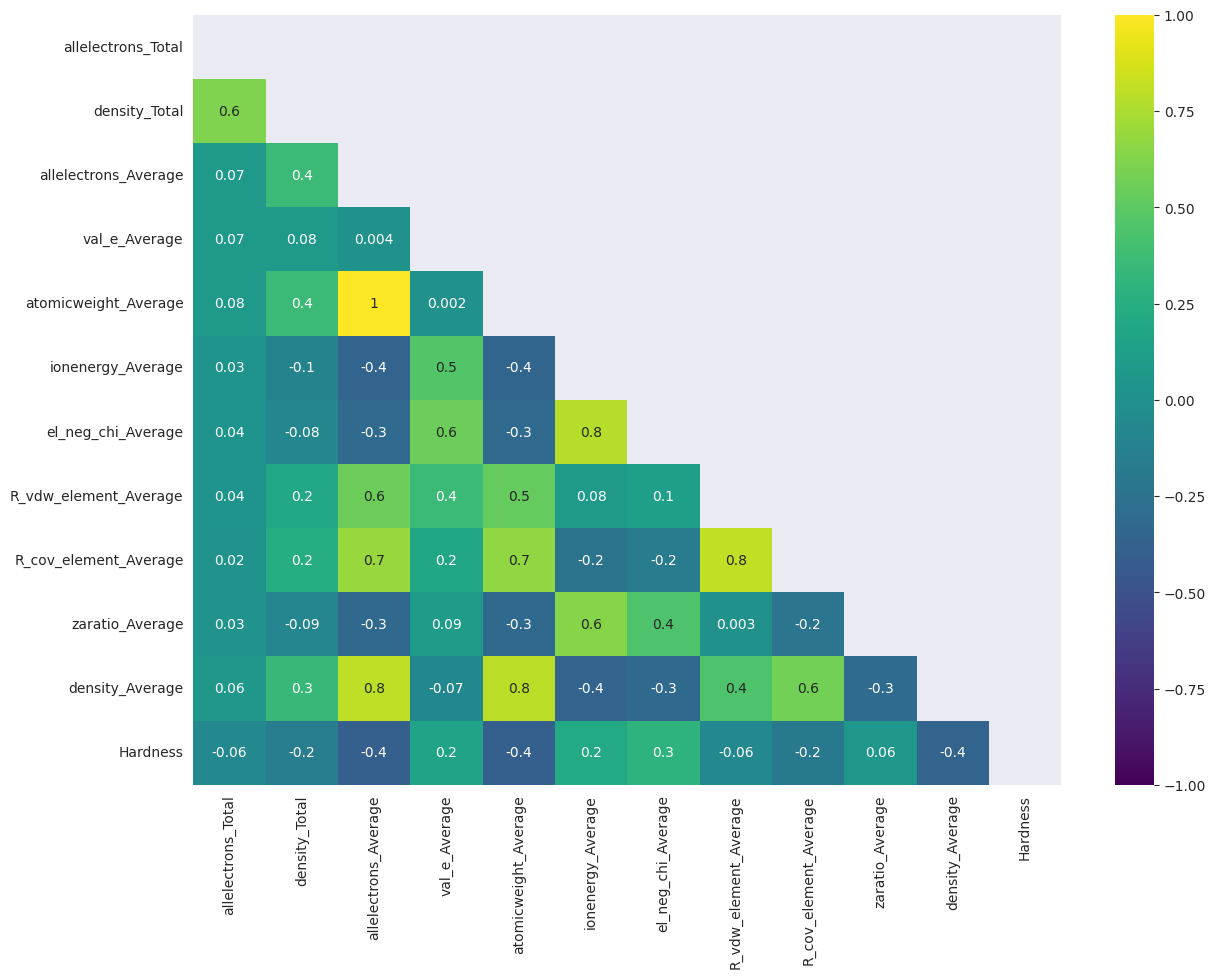

In [24]:
mask = np.triu(np.ones_like(train_data.corr()))
plt.figure(figsize=(14,10))
sns.heatmap(train_data.corr(), cmap="viridis", annot=True, mask=mask,vmin=-1,vmax=1,fmt=".1g");

In [25]:
fig,axes = plt.subplots(12,2,figsize=(15, 40),dpi=300)

for ind,col in enumerate(train_data.columns):
    plt.subplot(12,2,2*ind+1)
    sns.histplot(train_data[col],bins=15,kde=True)
    plt.gca().set_title(col)

    plt.subplot(12,2,2*ind+2)
    sns.boxplot(train_data[col],orient="h")
    plt.gca().set_title(col)

fig.tight_layout()
plt.show()

**Data preparation**

In [26]:
seed = np.random.seed(83110)

X = train_data.drop(["Hardness"],axis=1)
y = train_data["Hardness"]

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=seed)

In [28]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(6243, 11)
(2082, 11)
(2082, 11)


In [29]:
features = X.columns
print(features)

Index(['allelectrons_Total', 'density_Total', 'allelectrons_Average',
       'val_e_Average', 'atomicweight_Average', 'ionenergy_Average',
       'el_neg_chi_Average', 'R_vdw_element_Average', 'R_cov_element_Average',
       'zaratio_Average', 'density_Average'],
      dtype='object')


**Model training**

In [30]:
def calculate_metrics(y_true, y_pred, kind="test"):

    mae = mean_absolute_error(y_true,y_pred)
    rmse = mean_squared_error(y_true,y_pred, squared=False)
    print(f"Calculate metrics for {kind} data:\n")

    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")

In [31]:
params = {
    "n_estimators": None,
    "max_depth": None,
    "max_features": "sqrt",
    "min_samples_split": 5,
    "warm_start":False,
    "oob_score":True,
    "random_state": 0,
    "bootstrap": True,
}

In [32]:
score = defaultdict(dict)

n_estimators = [300, 400, 500, 600]
max_depths = [4, 5, 6, 7, 8]

for n_estimator in tqdm(n_estimators):
    for max_depth in tqdm(max_depths, leave=False):

        params["n_estimators"] = n_estimator
        params["max_depth"] = max_depth

        rf_reg = RandomForestRegressor(**params)
        rf_reg.fit(X_train, y_train)

        key = str(n_estimator) + "-" + str(max_depth)
        y_hat_val = rf_reg.predict(X_val)

        score[key]['oob'] = rf_reg.oob_score_
        score[key]['mae'] = mean_absolute_error(y_val,y_hat_val)
        score[key]['rmse'] = mean_squared_error(y_val,y_hat_val, squared=False)
        score[key]['params'] = params.copy()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [33]:
best_params = min(score.items(), key=lambda x: x[1]["mae"])
print(best_params)

('300-8', {'oob': 0.4287038784137548, 'mae': 0.9315147378142681, 'rmse': 1.2289469553149328, 'params': {'n_estimators': 300, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_split': 5, 'warm_start': False, 'oob_score': True, 'random_state': 0, 'bootstrap': True}})


In [34]:
rf_reg = RandomForestRegressor(**best_params[1]["params"])
rf_reg.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

RandomForestRegressor(max_depth=8, max_features='sqrt', min_samples_split=5,
                      n_estimators=300, oob_score=True, random_state=0)

In [35]:
print(rf_reg.oob_score_)

0.43701604761064516


In [36]:
calculate_metrics(pd.concat([y_train, y_val]), rf_reg.oob_prediction_, "oob error")

Calculate metrics for oob error data:

MAE: 0.95
RMSE: 1.26


In [37]:
y_hat = rf_reg.predict(X_test)

calculate_metrics(y_test, y_hat)

Calculate metrics for test data:

MAE: 0.92
RMSE: 1.21


**Feature importance**

In [38]:
history = pd.DataFrame()

def plotImportance(modelName,model):
    history["cols"] = X_test.columns
    history["imp"] = model.feature_importances_
    history.sort_values("imp",inplace=True,ascending=False)
    history.reset_index(drop=True)
    plt.figure(figsize=(15,5))
    sns.barplot(x=history["imp"],y=history["cols"],palette="viridis");
    plt.title("Feature Importance of "+modelName)

def plotPermutationImportance(modelName,result, metric):
    history["cols"] = X_test.columns
    x_name = f"imp ({metric})"
    history[x_name] = result[metric].importances_mean
    history.sort_values(x_name,inplace=True,ascending=False)
    history.reset_index(drop=True)
    plt.figure(figsize=(15,5))
    sns.barplot(x=history[x_name],y=history["cols"],palette="viridis");
    plt.title("Feature Importance of "+modelName)

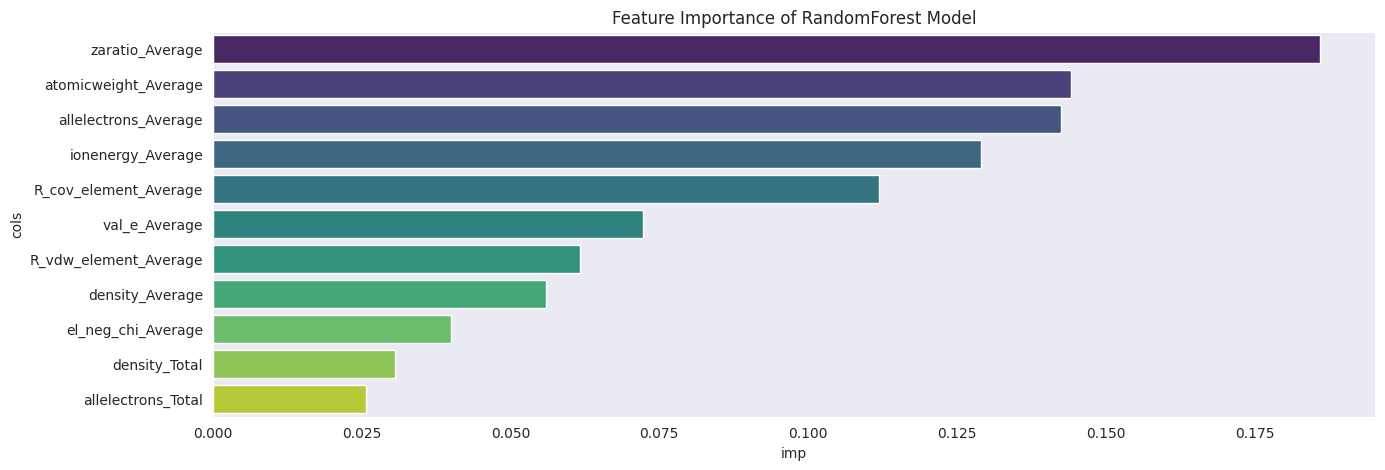

In [39]:
plotImportance("RandomForest Model",rf_reg)

In [40]:
scoring = ['neg_mean_absolute_error', 'neg_root_mean_squared_error']

result = permutation_importance(
    rf_reg, X_test, y_test, n_repeats=20, random_state=42, n_jobs=2, scoring=scoring
)

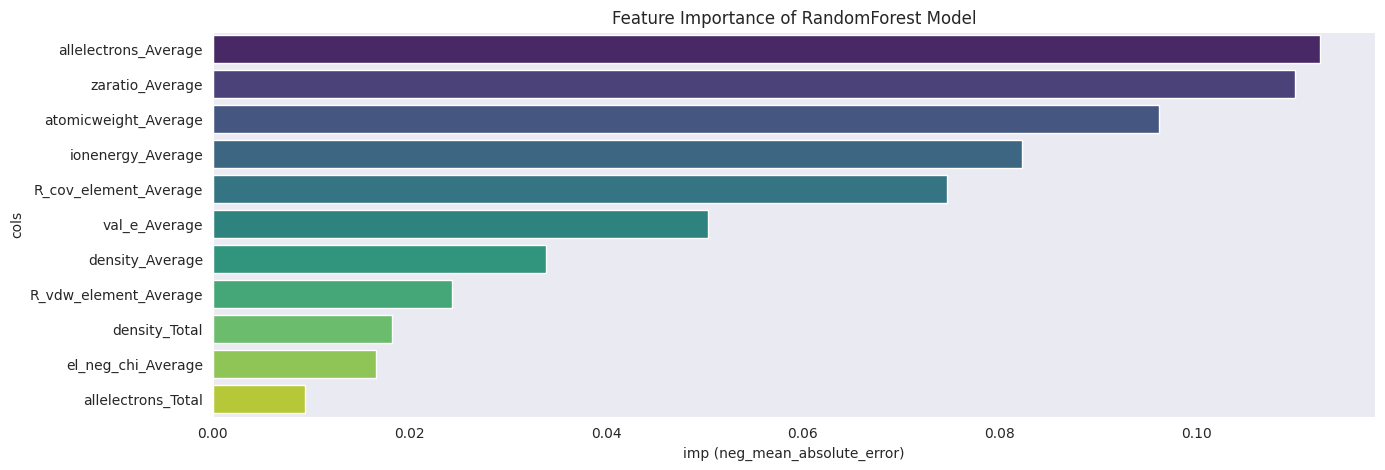

In [41]:
plotPermutationImportance("RandomForest Model", result, scoring[0])

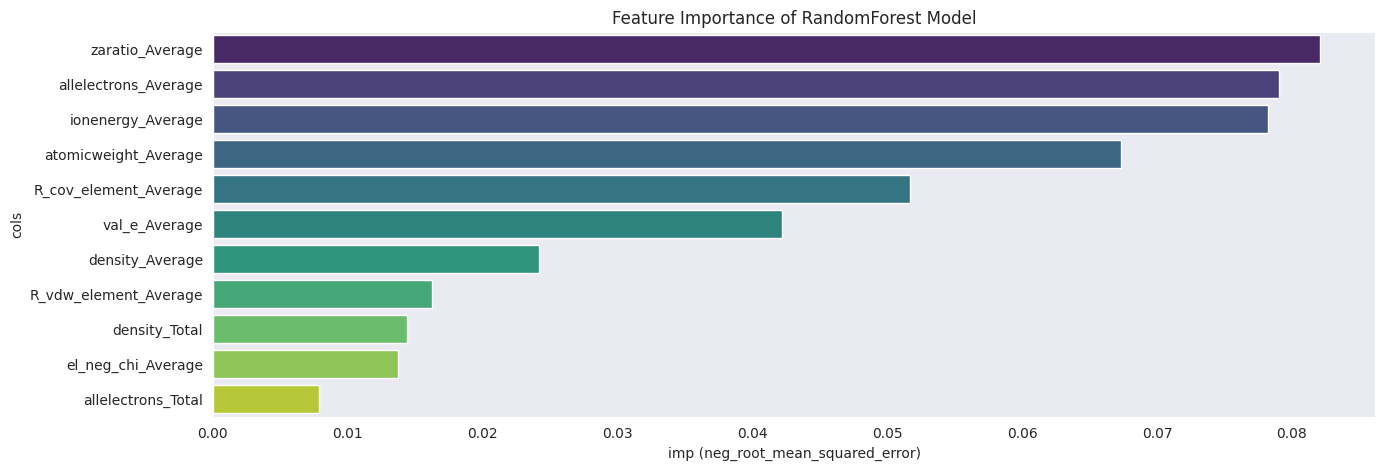

In [42]:
plotPermutationImportance("RandomForest Model", result, scoring[1])

**Partial Dependance**

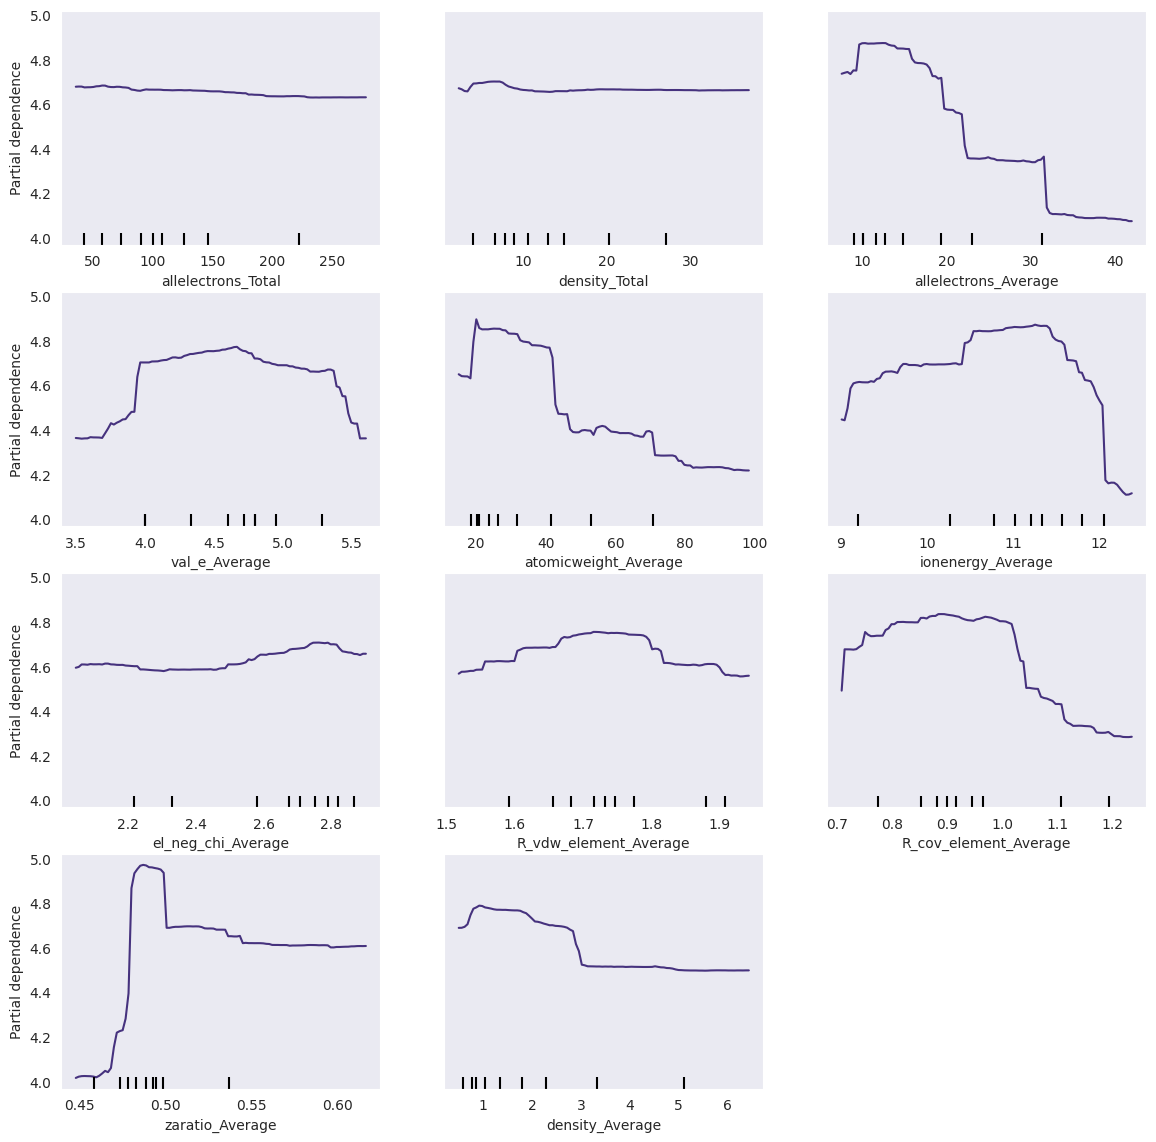

In [43]:
fig, ax = plt.subplots(figsize=(14, 14))
PartialDependenceDisplay.from_estimator(rf_reg, X, features, ax=ax)

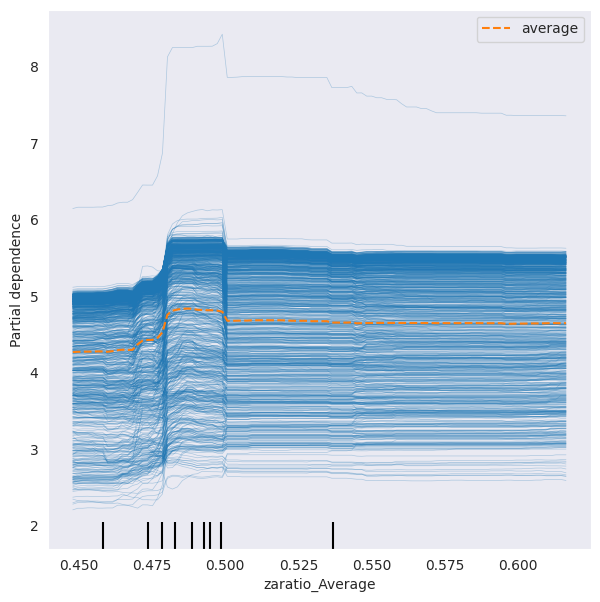

In [44]:
fig, ax = plt.subplots(figsize=(7, 7))
PartialDependenceDisplay.from_estimator(rf_reg, X, [features[9]],kind='both', ax=ax)

In [45]:
pdp_dist = pdp.PDPIsolate(model=rf_reg, df=X,
                          model_features=features,
                          feature="zaratio_Average",
                          feature_name="zaratio_Average",
                          n_classes=0)

# print(f"Value for point 0: {pdp_dist.results[0].ice_lines[0].mean()}")
X.drop("x",axis=1,inplace=True)
pdp_dist.plot(center=False)[0]

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

In [46]:
pdp_dist = pdp.PDPIsolate(model=rf_reg, df=X,
                          model_features=X.columns,
                          feature="ionenergy_Average",
                          feature_name="ionenergy_Average",
                          n_classes=0)

print(f"Value for point 0: {pdp_dist.results[0].ice_lines[0].mean()}")
X.drop("x",axis=1,inplace=True)
pdp_dist.plot(center=True)[0]

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

Value for point 0: 4.535834420669631


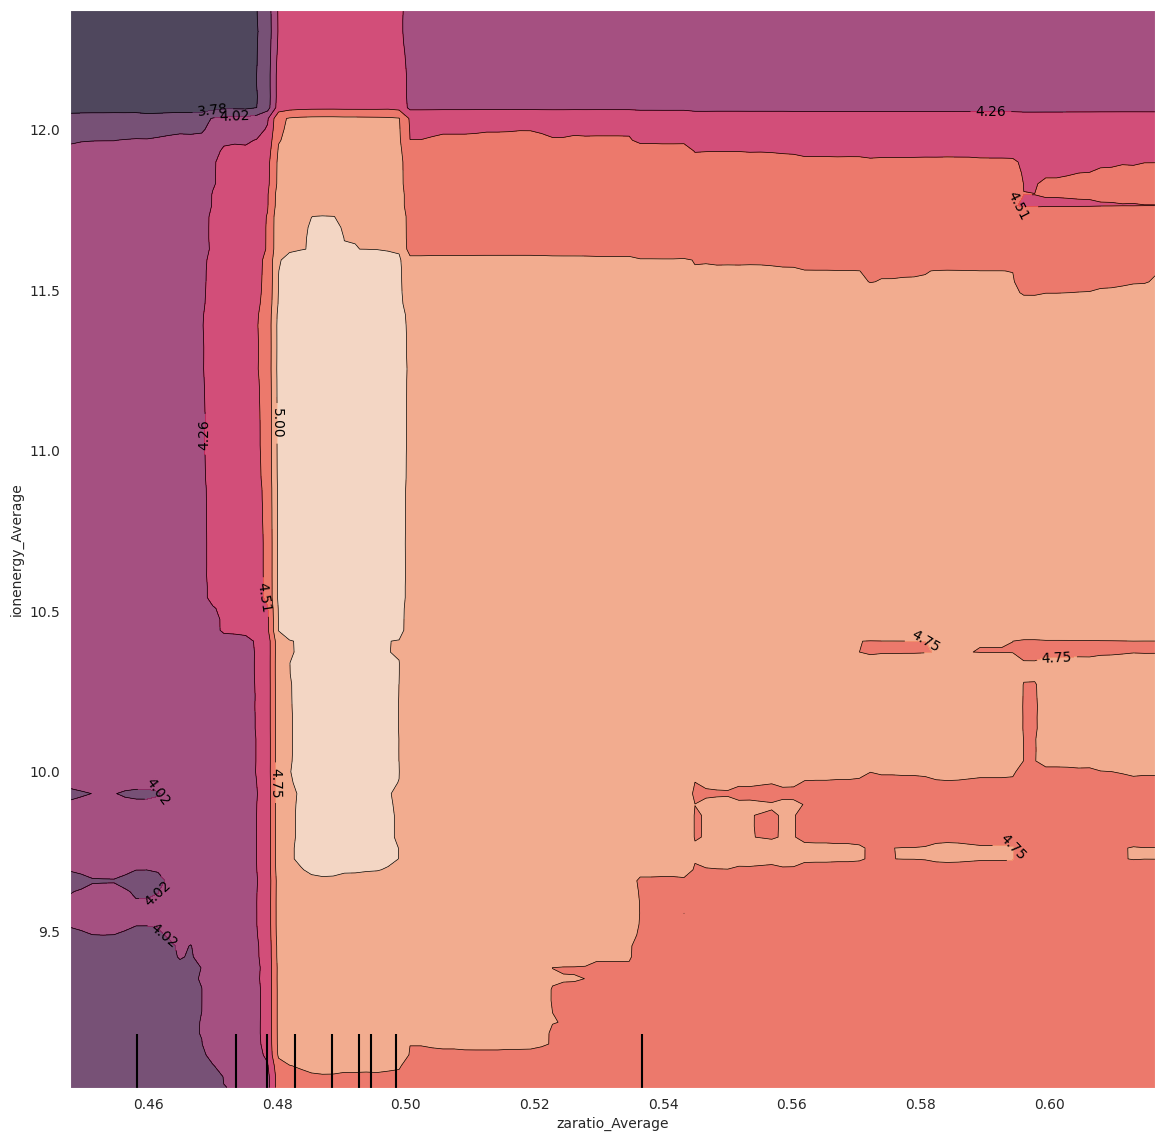

In [47]:
fig, ax = plt.subplots(figsize=(14, 14))
PartialDependenceDisplay.from_estimator(rf_reg, X, [("zaratio_Average", "ionenergy_Average")], ax=ax)

In [48]:
# X.drop("x",axis=1,inplace=True)

pdp_dist = pdp.PDPInteract(model=rf_reg, df=X,
                          model_features=X.columns,
                          features=["zaratio_Average", "ionenergy_Average"],
                          feature_names=["zaratio_Average", "ionenergy_Average"],
                          n_classes=0)

pdp_dist.plot()[0]

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/100 [00:00<?, ?it/s]

In [49]:
X.drop("x",axis=1,inplace=True)

**SHAP**

In [50]:
explainer = shap.Explainer(rf_reg)
shap_values = explainer(X)
shap.initjs()

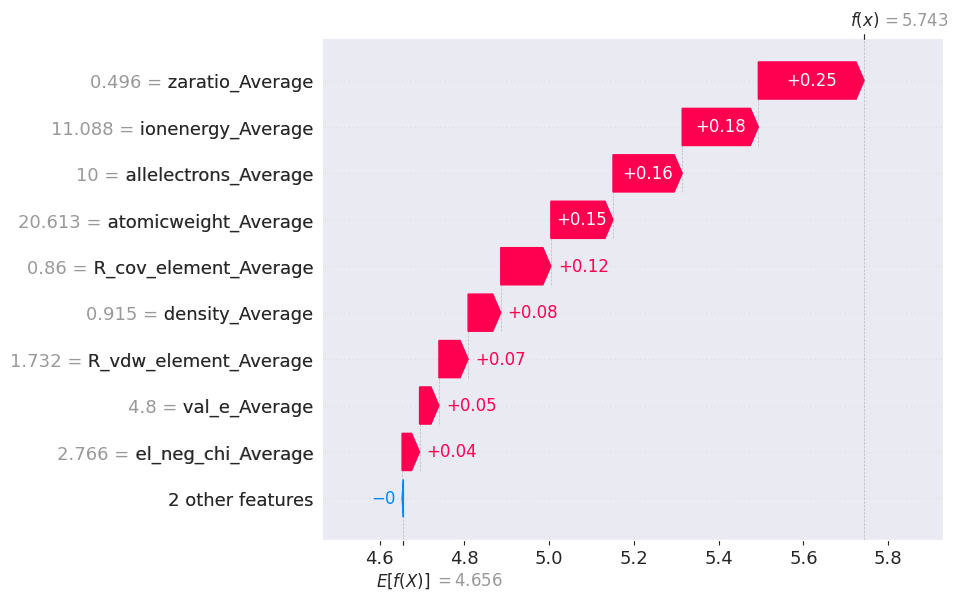

In [51]:
shap.plots.waterfall(shap_values[0])

In [ ]:
shap.plots.force(shap_values[0])

In [ ]:
shap.plots.force(shap_values[2])

In [ ]:
shap.plots.force(shap_values[:500])

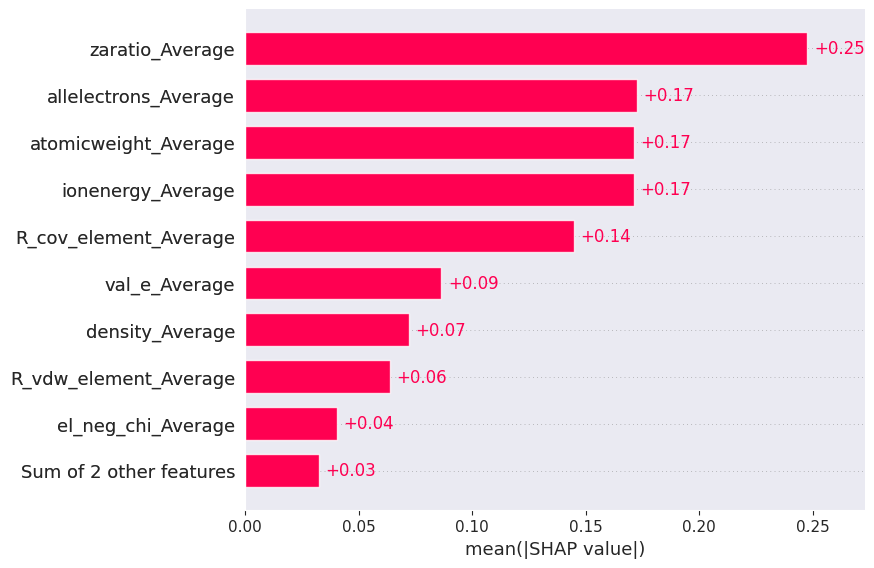

In [55]:
shap.plots.bar(shap_values)

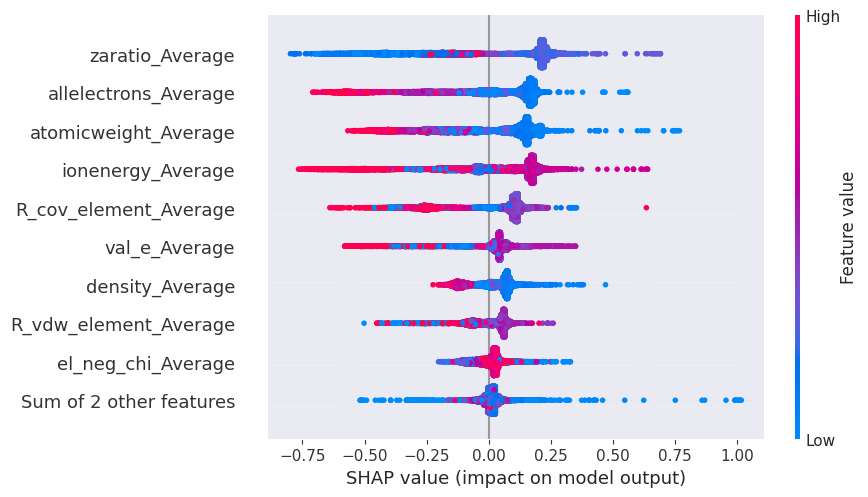

In [56]:
shap.plots.beeswarm(shap_values)

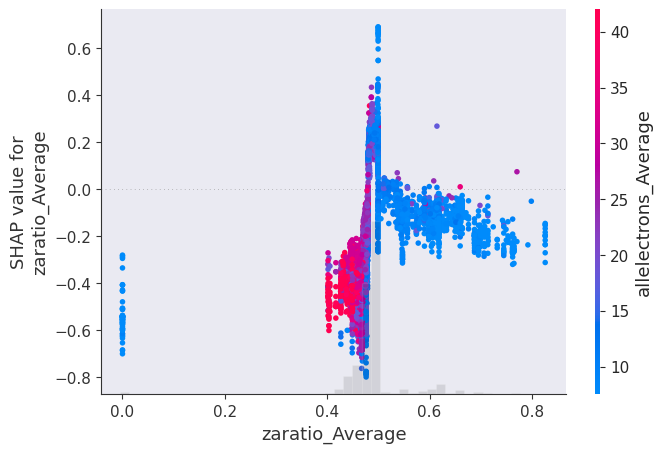

In [57]:
shap.plots.scatter(shap_values[:, "zaratio_Average"], color=shap_values)

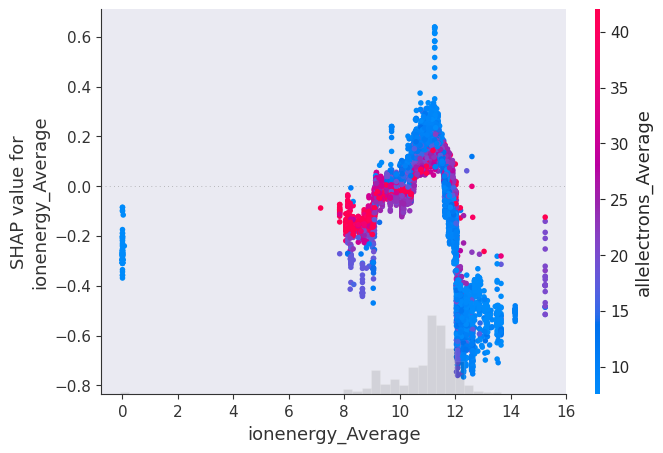

In [58]:
shap.plots.scatter(shap_values[:, "ionenergy_Average"], color=shap_values)

In [59]:
data_point = 929

explainer = shap.TreeExplainer(rf_reg)

print(f"Correct hardness: {y_test.loc[data_point]}")
X_test.loc[[data_point]]

Correct hardness: 3.299999952316284


allelectrons_Total  density_Total  allelectrons_Average  val_e_Average  \
id                                                                              
929.0               106.0      18.952663             38.666668       3.333333   

       atomicweight_Average  ionenergy_Average  el_neg_chi_Average  \
id                                                                   
929.0             92.697334           8.869433                2.18   

       R_vdw_element_Average  R_cov_element_Average  zaratio_Average  \
id                                                                     
929.0               1.943333               1.193333         0.446357   

       density_Average  
id                      
929.0          6.44467

In [ ]:
choosen_instance = X_test.loc[[data_point]]
shap_value = explainer.shap_values(choosen_instance)
shap.force_plot(explainer.expected_value[0], shap_value[0], choosen_instance)

**Local interpretable model-agnostic explanations (LIME)**

In [61]:
print(f"Correct hardness: {y_test.loc[data_point]}")
X_test.loc[[data_point]]

Correct hardness: 3.299999952316284


allelectrons_Total  density_Total  allelectrons_Average  val_e_Average  \
id                                                                              
929.0               106.0      18.952663             38.666668       3.333333   

       atomicweight_Average  ionenergy_Average  el_neg_chi_Average  \
id                                                                   
929.0             92.697334           8.869433                2.18   

       R_vdw_element_Average  R_cov_element_Average  zaratio_Average  \
id                                                                     
929.0               1.943333               1.193333         0.446357   

       density_Average  
id                      
929.0          6.44467

In [62]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.to_numpy(), feature_names=features, class_names=['Hardness'], verbose=True, mode='regression', kernel_width=None)
exp = explainer.explain_instance(X_test.loc[data_point], rf_reg.predict, num_features=5)
exp.show_in_notebook(show_table=True)

Intercept 4.947623380308237
Prediction_local [3.48362314]
Right: 2.7676964975129605


In [63]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.to_numpy(), feature_names=features, class_names=['Hardness'], verbose=True, mode='regression', kernel_width=np.sqrt(X_train.to_numpy().shape[1])*1)
exp = explainer.explain_instance(X_test.loc[data_point], rf_reg.predict, num_features=9)
exp.show_in_notebook(show_table=True)

Intercept 5.014689907794179
Prediction_local [3.30719115]
Right: 2.7676964975129605
